In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

Data prep

In [3]:
df = pd.read_csv('datasets/PJME_hourly.csv')
# print(df.head())
# print(df.tail())
df = df.set_index('Datetime')     # setting Datetime as index(we no longer have column with index)
# print(df.head())
# print(df.tail())
df.index = pd.to_datetime(df.index) # formatting datetime as date format
# df.plot(style='.', figsize=(15, 5), color=color_pal[0], title='PJME Energy use in MW')

Visualizing Train / Test split

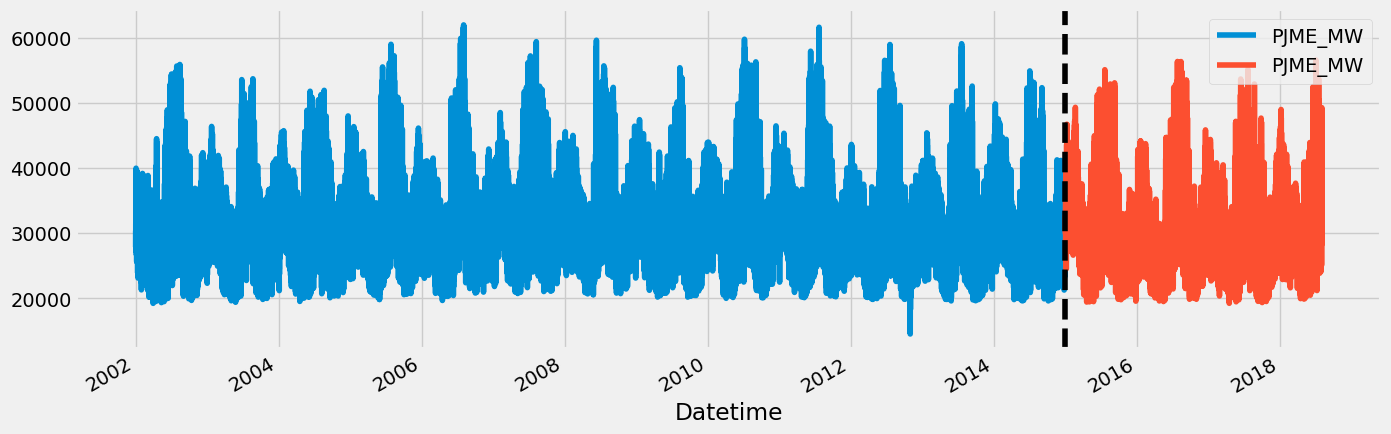

In [4]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training set')
test.plot(ax=ax, label='Training set')
ax.axvline('01-01-2015', color='black', ls='--')

Outlier Removal

<AxesSubplot:xlabel='Datetime'>

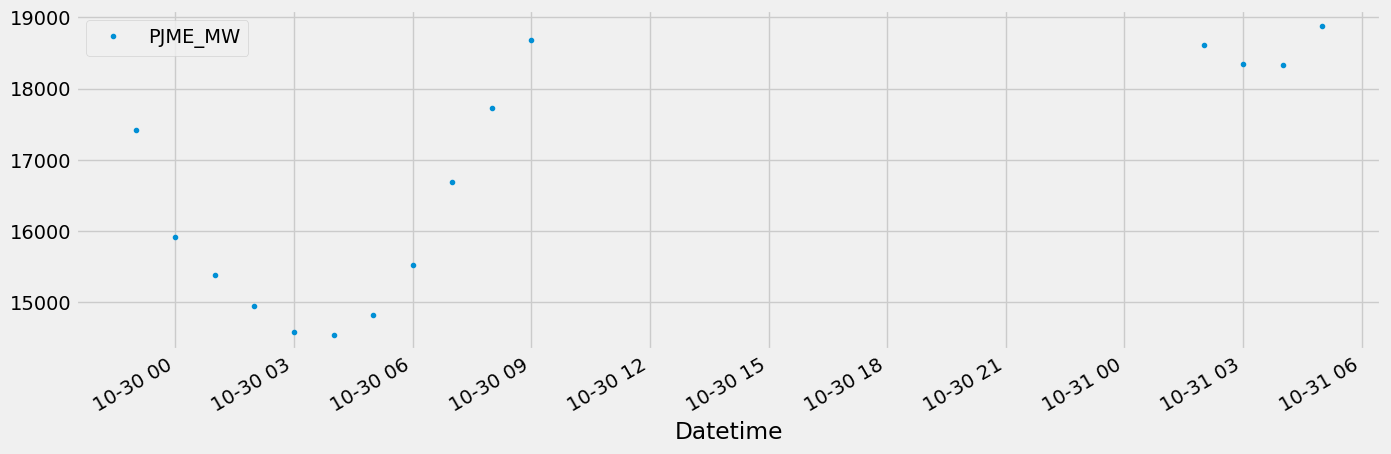

In [5]:
df.query('PJME_MW < 19000').plot(figsize=(15,5), style='.')

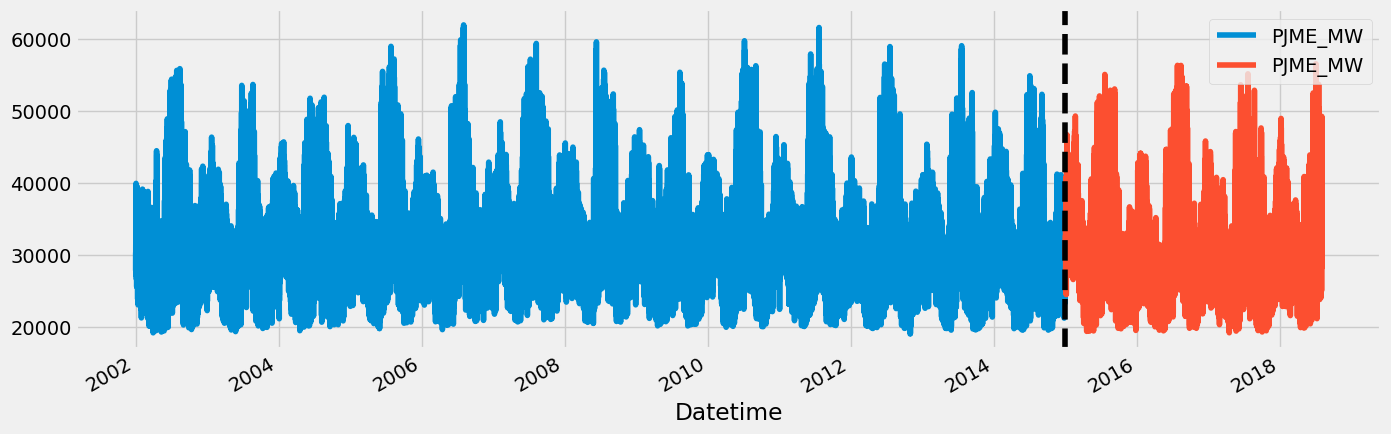

In [6]:
df = df.query('PJME_MW > 19000').copy() # Outlier filtered

train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training set')
test.plot(ax=ax, label='Training set')
ax.axvline('01-01-2015', color='black', ls='--')

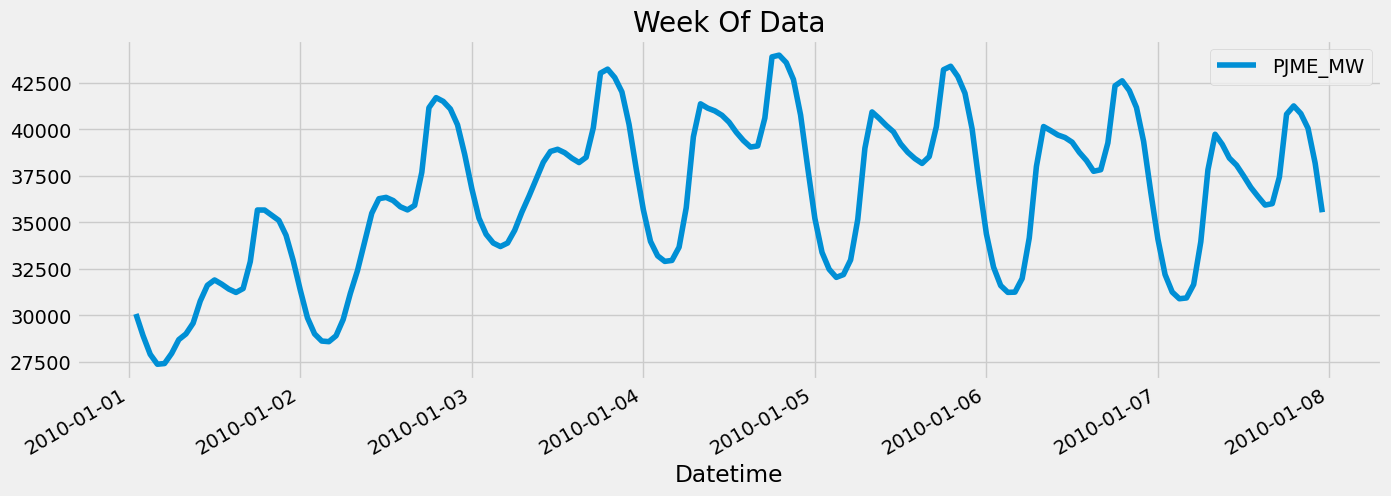

In [7]:
# Visualizing only one week of data
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Time series cross validation

In [8]:
from sklearn.model_selection import TimeSeriesSplit

In [9]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24) #5 years, predicting hourly for 1 year, 24 hours
df = df.sort_index() # need to sort time series or it will not work

for train_idx, val_idx in tss.split(df):
    break

In [10]:
val_idx

array([101551, 101552, 101553, ..., 110308, 110309, 110310])

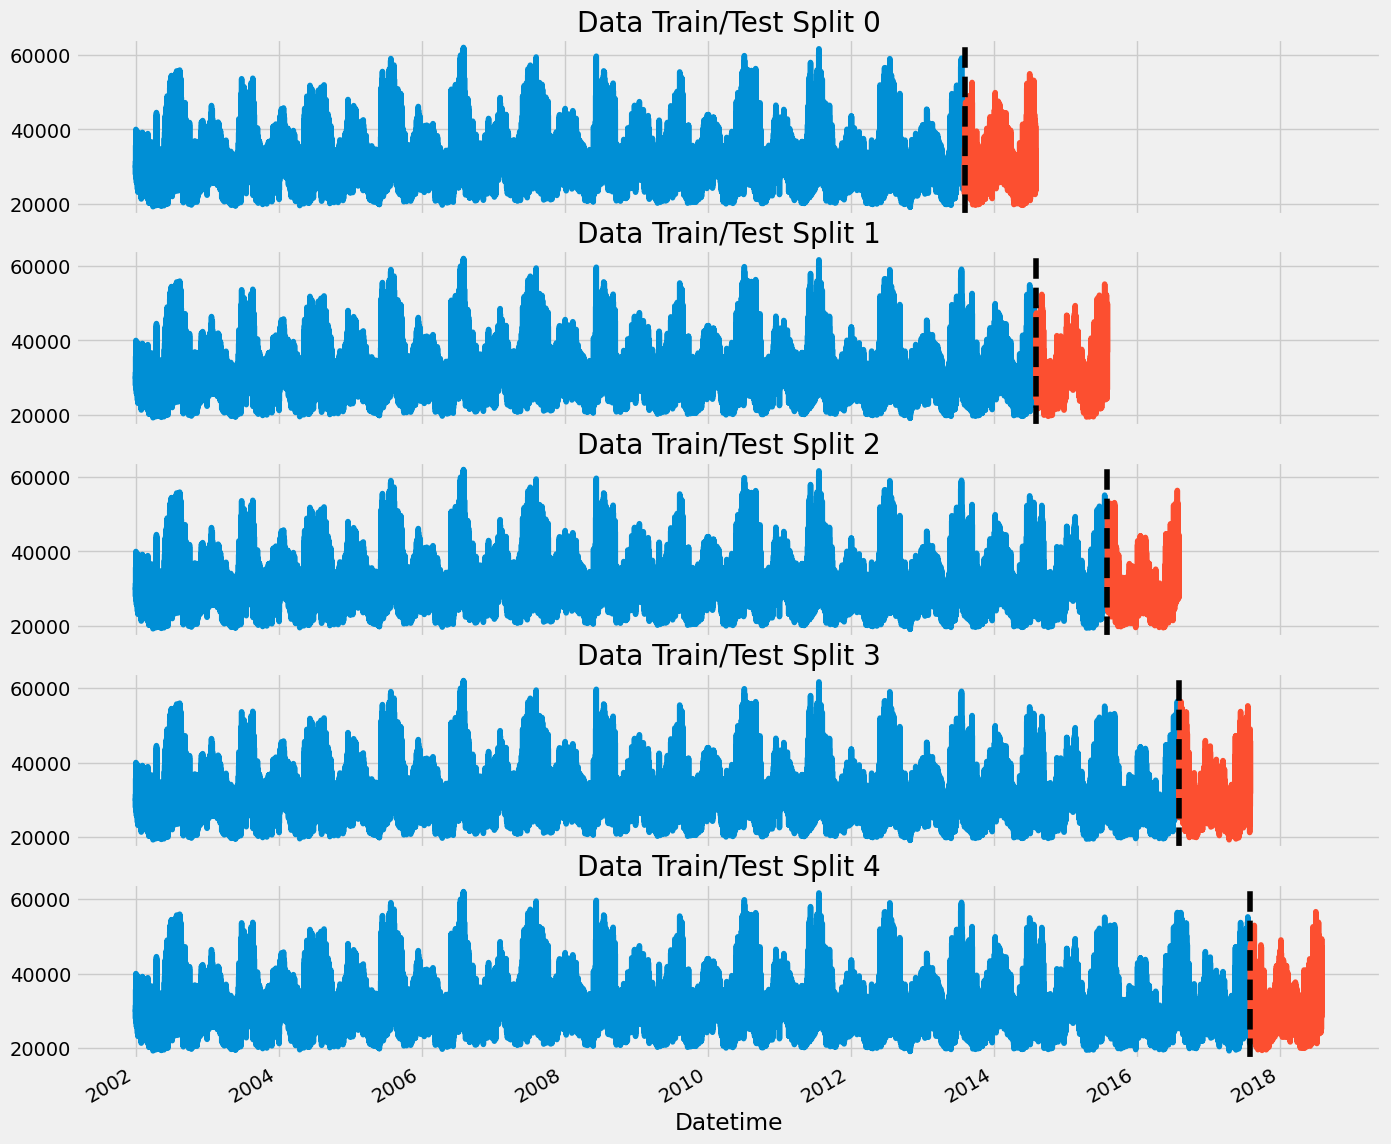

In [11]:
fig,axs = plt.subplots(5,1, figsize=(15,15),
                            sharex=True)               # sharing x axis x axis is the same
fold = 0                                                # we track our fold (could be done with enumerate)
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold], label='Training set', title=f'Data Train/Test Split {fold}')
    test['PJME_MW'].plot(ax=axs[fold], label='Test set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

Feature creation   

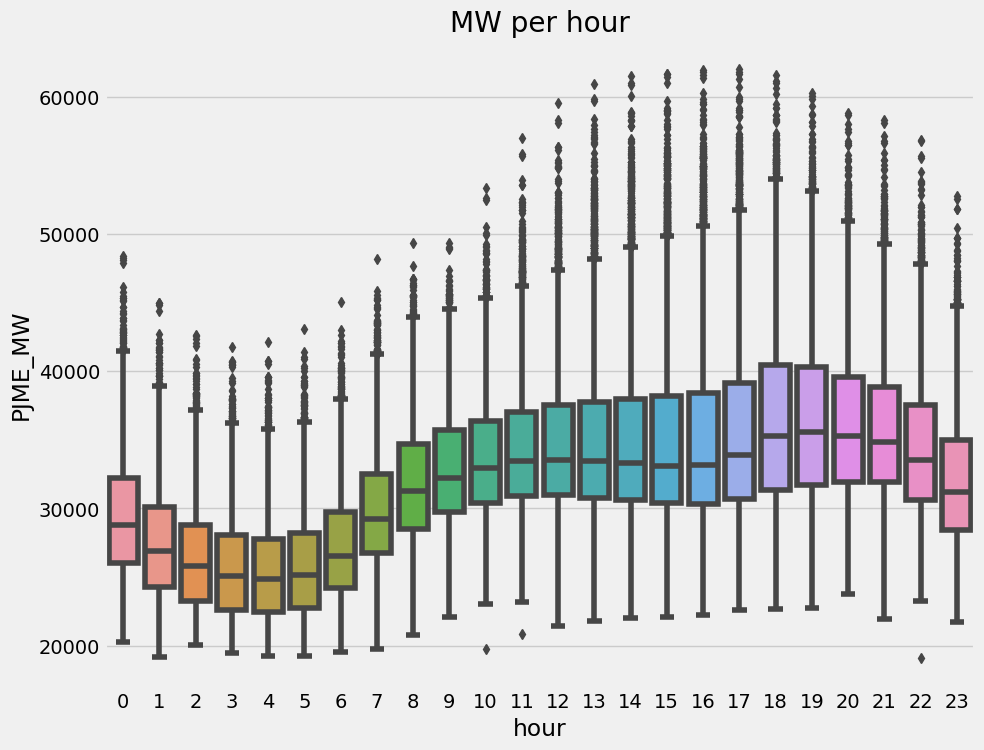

In [12]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

# Visualizing feature vs target relationship
plt.figure(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
plt.title('MW per hour')
# print(df.columns)
# ['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear','dayofmonth', 'weekofyear']
# plt.show()

from sklearn.metrics import mean_squared_error
import xgboost as xgb

train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

Creating XGBoost regressor model

In [13]:
reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=50,            # model will stop after 50 trees
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32460.79036	validation_1-rmse:31463.35776
[100]	validation_0-rmse:12306.85165	validation_1-rmse:11758.20765
[200]	validation_0-rmse:5392.96800	validation_1-rmse:5515.97967
[300]	validation_0-rmse:3442.86104	validation_1-rmse:4128.44593
[400]	validation_0-rmse:2967.26208	validation_1-rmse:3940.56437
[500]	validation_0-rmse:2811.96963	validation_1-rmse:3922.20039
[549]	validation_0-rmse:2767.04882	validation_1-rmse:3923.15061


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

Feature importance (manual)

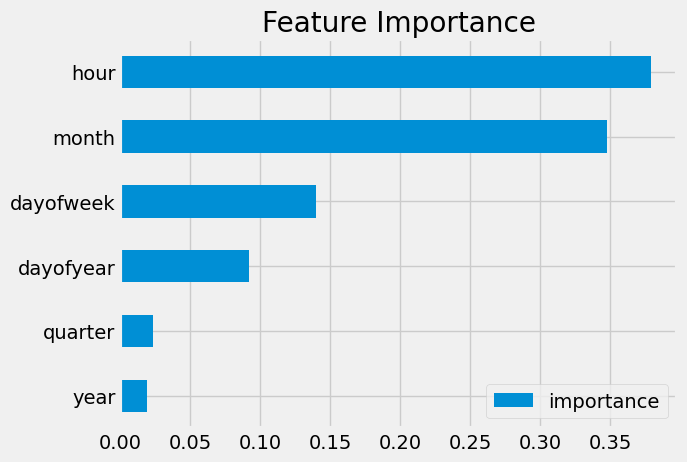

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

Feature importance with SHAP

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


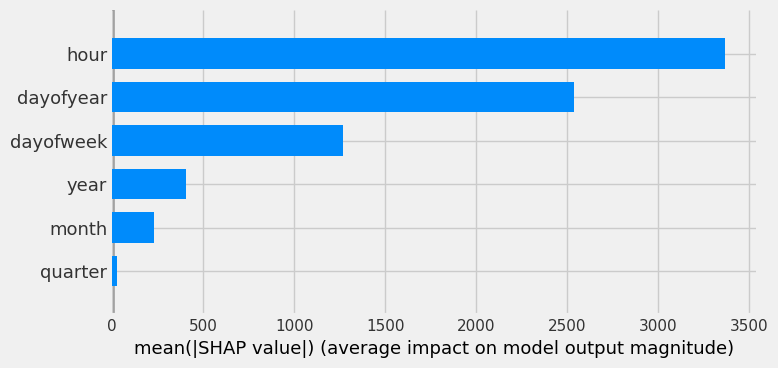

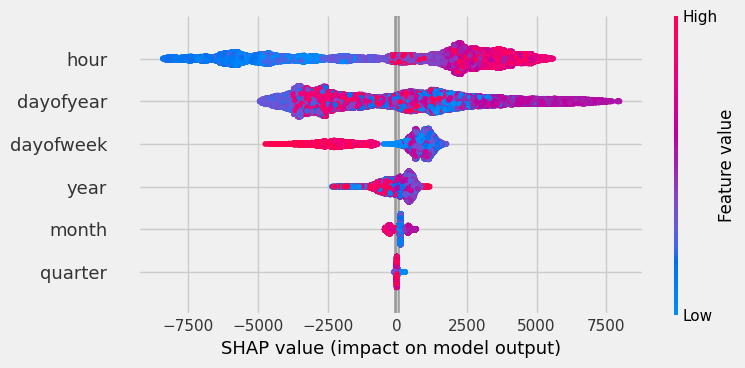

In [ ]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar')
shap.summary_plot(shap_values, X_train)

Forecast on the test set

In [ ]:
print(reg.predict(X_test))

[31815.514 28353.748 27203.926 ... 34874.39  33126.223 31815.514]


In [ ]:
predictions = reg.predict(X_test)
# RMSE  
rmse = np.sqrt(np.mean(((predictions - y_test)**2)))
print('The RMSE for the model is: %.2f' % rmse)

The RMSE for the model is: 3714.70


Plotting - since 2015

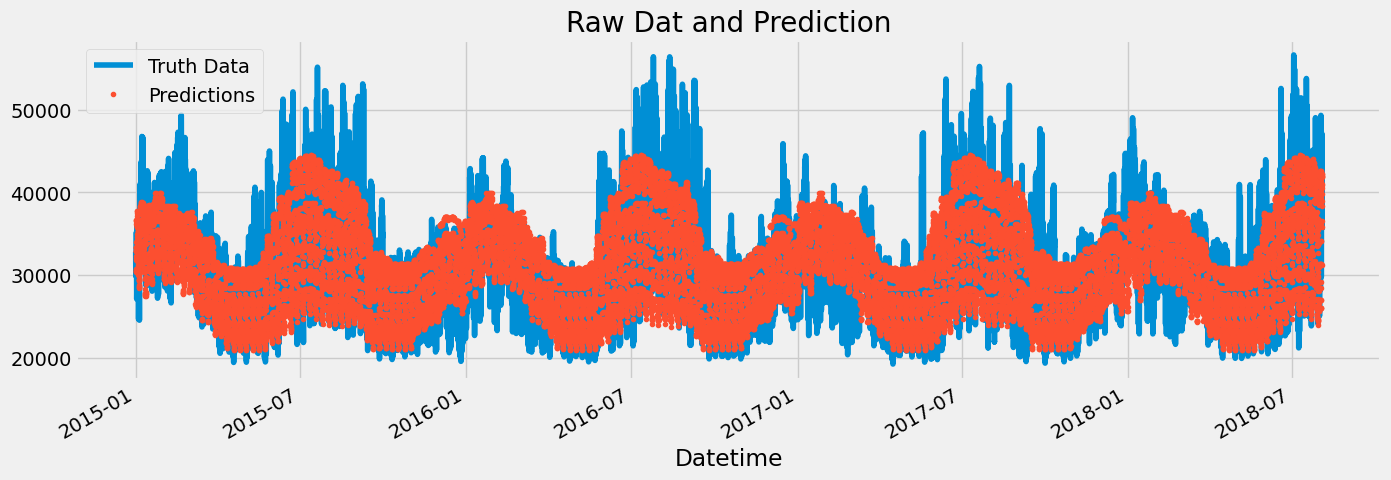

In [ ]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

Plotting - one week

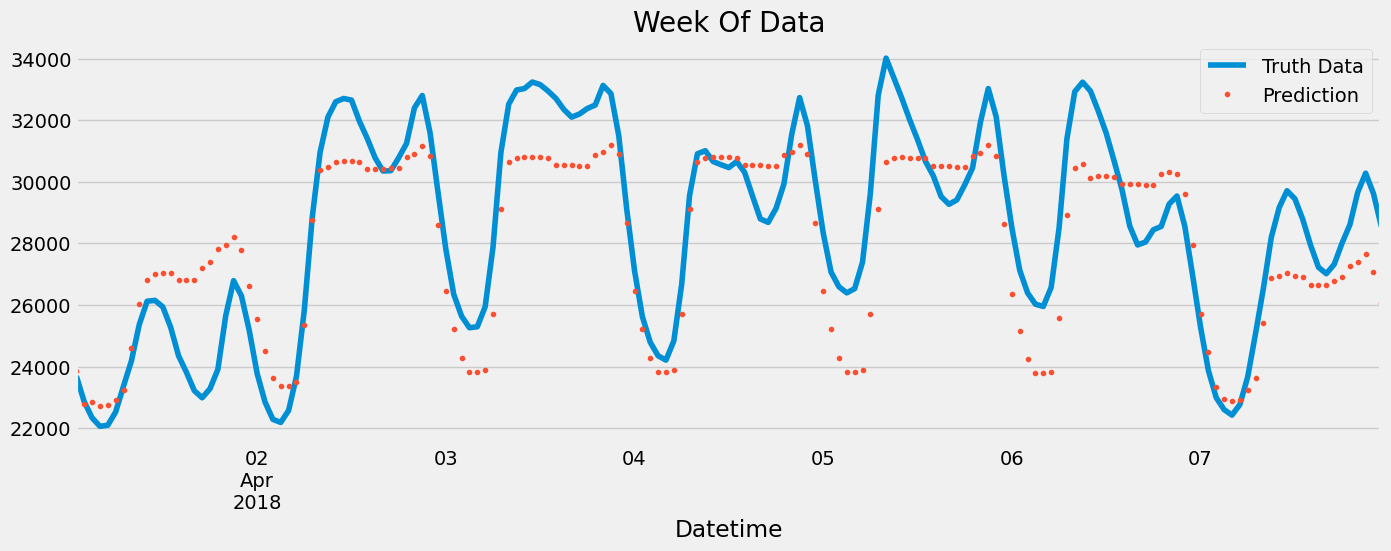

In [ ]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

Calculate the highest and the lowest errors

In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction']) #absolute value
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    14559.813965
2016-08-14    14393.350830
2016-09-10    12564.790202
2016-08-12    11527.895264
2016-09-09    11432.962240
2018-01-06    10954.087809
2015-02-20    10897.302409
2016-08-11    10353.233968
2018-01-07    10226.969808
2017-05-19    10196.744385
Name: error, dtype: float64

In [ ]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

date
2016-09-27    376.074788
2016-05-01    420.460449
2016-04-04    432.775065
2015-03-10    444.994792
2016-12-08    480.121745
2015-10-28    503.434977
2015-09-25    506.318197
2017-06-16    526.978109
2015-10-03    536.472168
2018-05-17    548.753743
Name: error, dtype: float64